In [1]:
import numpy as np
import fbpca 


def prep_data():
    x = np.loadtxt("simulated_genos", delimiter=" ", dtype="float32")
    y = np.array([[1] * 10000 + [0] * 10000], dtype="float32")
    y_c = y - 0.5
    return x, y_c

x, y_c = prep_data()
print (x.shape)


(20000, 50)


In [2]:
# fbpca

%time sig_rsvd_fbpca = fbpca.pca(x,50,True)[1]
eig_rsvd_fbpca = sig_rsvd_fbpca ** 2
print (eig_rsvd_fbpca)


CPU times: user 51.5 ms, sys: 21.6 ms, total: 73.1 ms
Wall time: 102 ms
[ 40.00001144  38.08315277  37.10234833  37.06640244  37.00000763
  33.04753876  31.16459846  29.1289978   29.07105446  29.03992844
  28.99998474  28.00000381  27.65703964  26.03939819  25.52819252
  25.03122902  25.00000572  24.00005341  23.99998283  22.00000954
  21.93363762  21.00001335  20.68578529  20.00000572  20.00000572
  19.80418396  17.82784653  16.94734573  16.          15.99999428
  14.92892456  13.00000191  11.99999332  11.95249748  11.00000381
  10.99999619  10.00000668  10.00000286  10.           9.00000286
   7.99999857   7.00000095   7.00000095   6.99999952   6.00000286   5.           4.
   4.           3.96006298   1.        ]


In [3]:
#randomized SVD
def randomized_svd(M, k=10):
    m, n = M.shape
    transpose = False
    if m < n:
        transpose = True
        M = M.T
        
    rand_matrix = np.random.normal(size=(M.shape[1], k))  # short side by k
    Q, _ = np.linalg.qr(M @ rand_matrix, mode='reduced')  # long side by k
    smaller_matrix = Q.T @ M                              # k by short side
    U_hat, s, V = np.linalg.svd(smaller_matrix, full_matrices=False)
    U = Q @ U_hat
    
    if transpose:
        return V.T, s.T, U.T
    else:
        return U, s, V
    
%time sig_rsvd = randomized_svd(x,50)[1]
eig_rsvd = sig_rsvd_fbpca ** 2
print (eig_rsvd)

CPU times: user 116 ms, sys: 35.3 ms, total: 151 ms
Wall time: 106 ms
[ 40.00001144  38.08315277  37.10234833  37.06640244  37.00000763
  33.04753876  31.16459846  29.1289978   29.07105446  29.03992844
  28.99998474  28.00000381  27.65703964  26.03939819  25.52819252
  25.03122902  25.00000572  24.00005341  23.99998283  22.00000954
  21.93363762  21.00001335  20.68578529  20.00000572  20.00000572
  19.80418396  17.82784653  16.94734573  16.          15.99999428
  14.92892456  13.00000191  11.99999332  11.95249748  11.00000381
  10.99999619  10.00000668  10.00000286  10.           9.00000286
   7.99999857   7.00000095   7.00000095   6.99999952   6.00000286   5.           4.
   4.           3.96006298   1.        ]


In [4]:

#exact:
from scipy import sparse
import scipy.sparse.linalg as lg
X_sparse = sparse.csr_matrix(x)
X_T_sparse = sparse.csr_matrix.transpose(X_sparse)
XX = X_sparse@X_T_sparse
%time eig_exact = lg.eigsh(XX,k=50)
eig_exact = eig_exact[0]
eig_exact_sorted = sorted(eig_exact,reverse = True)
print (eig_exact_sorted)


CPU times: user 193 ms, sys: 7.88 ms, total: 201 ms
Wall time: 116 ms
[40.000004, 38.083111, 37.102303, 37.066376, 37.0, 33.047508, 31.164608, 29.128977, 29.071066, 29.039927, 28.999994, 27.999996, 27.657045, 26.039396, 25.5282, 25.031216, 24.999994, 24.000002, 23.999996, 21.999994, 21.933632, 21.000002, 20.685768, 20.0, 19.99999, 19.804171, 17.827816, 16.947344, 15.999999, 15.999992, 14.928935, 13.000005, 12.0, 11.952488, 11.000002, 10.999996, 10.000003, 10.000001, 9.999999, 9.0000029, 8.0000019, 7.0000081, 7.000001, 6.9999986, 6.0000091, 5.0000143, 4.0000048, 3.9999919, 3.9600658, 0.99999535]


In [5]:
# compare approximate methods to exact method's eigen
eig_rsvd = list(eig_rsvd)

total_error = 0
for i in range(len(eig_rsvd)):
    error = abs(eig_rsvd[i]-eig_exact_sorted[i])
    total_error += error
mean_error = total_error/len(eig_rsvd)
print ("total error: ")
print (total_error)
print ("average error:")
print (mean_error)

total error: 
0.000535845756531
average error:
1.07169151306e-05


0.421475


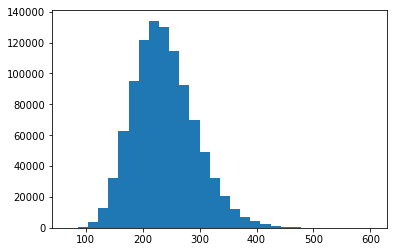

In [6]:
# Monte Carlo, simulate the distribution of Q
import matplotlib.pyplot as plt
%matplotlib inline


N = 1000000

Q_distribution = []
for i in range(N):
    #generate 50 chi-square r.v
    sample = np.random.chisquare(1, size=50)
    Q_stat = np.sum(eig_exact * sample)/4
    Q_distribution.append(Q_stat)
    

#print (Q_distribution)
plt.hist(Q_distribution, bins = 30)
q = 223.25
def inverse_percentile(arr, num):
    arr = sorted(arr)
    i_arr = [i for i, x in enumerate(arr) if x > num]

    return i_arr[0] / len(arr) if len(i_arr) > 0 else 1
p = inverse_percentile(Q_distribution, q)
print (p)



In [42]:
# compute p-value


<class 'list'>


In [14]:
#generate 50 random eigen value according to N(real eigen value,0.1)

print (eig_exact)
random_eigen = [0]*50
for i in range(50):
    random_eigen[i]= float(np.random.normal(eig_exact[i], 0.1, 1))
print (random_eigen)

[  0.99999535   3.96006584   3.99999189   4.00000477   5.00001431
   6.00000906   6.99999857   7.00000095   7.00000811   8.00000191
   9.00000286   9.99999905  10.00000095  10.00000286  10.99999619
  11.00000191  11.95248795  12.          13.00000477  14.92893505
  15.99999237  15.99999905  16.94734383  17.82781601  19.80417061
  19.99999046  20.          20.68576813  21.00000191  21.9336319
  21.99999428  23.99999619  24.00000191  24.99999428  25.03121567
  25.52820015  26.03939629  27.65704536  27.99999619  28.99999428
  29.03992653  29.0710659   29.12897682  31.164608    33.04750824  37.
  37.06637573  37.10230255  38.08311081  40.00000381]
[1.090381828404982, 3.6544120700003173, 3.853470298819047, 4.100314342860556, 4.95136639625486, 6.0319050306719335, 6.960327401814914, 7.088358782519001, 7.131703304193694, 7.94526006919528, 8.914879378086741, 9.986828588262478, 10.101635639735028, 10.0416356412474, 10.851856390423798, 11.024606208201456, 12.07167724666997, 12.079966335085201, 13

In [27]:
#generate K*50, orthogonal matrix, K >50
import scipy
K = 100
a = np.random.random(size=(K, 50))
q = scipy.linalg.orth(a)
print (q)
I = np.identity(50)
E = I*random_eigen
M = q @ E @ q.T
print (M)

[[-0.0973257   0.11556493  0.08731847 ...,  0.02507832  0.06528766
   0.01759556]
 [-0.11334519  0.14854615 -0.1579003  ...,  0.0657426   0.04356572
  -0.09522703]
 [-0.11026109  0.00578262  0.01771882 ...,  0.18526249  0.14341826
  -0.16599502]
 ..., 
 [-0.10235634  0.04291876  0.05122064 ..., -0.043659   -0.1681546
   0.1182403 ]
 [-0.09778275 -0.08527034 -0.21115958 ..., -0.04515087 -0.05654244
   0.13090622]
 [-0.09178478 -0.22044286  0.02379291 ..., -0.06872249 -0.19076769
   0.10581162]]
(100, 100)


In [31]:
import time

X_sparse = sparse.csr_matrix(q)
X_T_sparse = sparse.csr_matrix.transpose(X_sparse)
XX = X_sparse@E@X_T_sparse
start_time = time.clock()
eig_2 = lg.eigsh(XX,k=50)
end_time = time.clock()
eig_2 = eig_2[0]
print (eig_2)
print (end_time - start_time)

[  1.09038183   3.65441207   3.8534703    4.10031434   4.9513664
   6.03190503   6.9603274    7.08835878   7.1317033    7.94526007
   8.91487938   9.98682859  10.04163564  10.10163564  10.85185639
  11.02460621  12.07167725  12.07996634  13.10720673  14.89400517
  15.78729028  15.92464574  16.89560816  17.79305635  19.79393291
  20.04774821  20.1962631   20.69059334  21.01870514  21.86580759
  21.96688844  23.91758592  24.0203702   25.08541787  25.13036473
  25.56806021  26.13679773  27.72787806  28.02921916  29.01673004
  29.09122518  29.1829897   29.19702697  31.11412873  33.28228405
  37.04064316  37.07198378  37.25957637  38.06661282  39.96201786]
0.01096899999999934


(0.00524902299999917, array([  1.07042263,   3.88847997,   3.91954555,   4.02155654,
         5.12766639,   5.89313308,   6.9530751 ,   7.0012983 ,
         7.19444368,   8.10682994,   9.04966198,   9.80336425,
         9.83089019,  10.07918536,  10.96196389,  11.06235327,
        11.89035624,  12.11788171,  13.07394175,  14.76239531,
        15.90512725,  16.01414024,  17.00351365,  17.87744637,
        19.78752863,  20.0031318 ,  20.0464879 ,  20.8550785 ,
        20.93276191,  21.79857358,  21.96992874,  23.86702913,
        24.02494727,  24.96627638,  25.14302706,  25.5509677 ,
        26.01233751,  27.71491217,  28.08811381,  29.00288825,
        29.07165083,  29.16051431,  29.20807506,  31.10977925,
        32.80298801,  36.99257841,  37.05965941,  37.13969989,
        37.94605951,  39.97900011]))
[0.00031658900000024914, 0.0003871160000001055, 0.00043879900000047203, 0.0004686599999995451, 0.0005894370000021354, 0.0005498940000002221, 0.000747791999999663, 0.0007716670000020258,

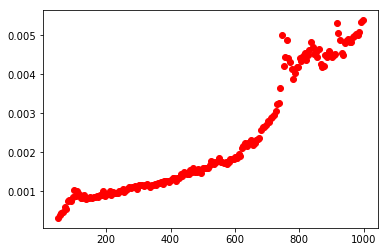

In [46]:
# function to test average running time for computing eigen
def test_eigen_1(K):
    random_eigen = [0]*50
    for i in range(50):
        random_eigen[i]= float(np.random.normal(eig_exact[i], 0.1, 1))
    a = np.random.random(size=(K, 50))
    q = scipy.linalg.orth(a)
    I = np.identity(50)
    E = I*random_eigen
    M = q @ E @ q.T
    X_sparse = sparse.csr_matrix(q)
    X_T_sparse = sparse.csr_matrix.transpose(X_sparse)
    XX = X_sparse@E@X_T_sparse
    time_list = []
    for j in range(100):
        start_time = time.clock()
        eig_2 = lg.eigsh(XX,k=50)
        end_time = time.clock()
        time_list.append(end_time-start_time)
    average_time = sum(time_list)/1000
    eig_2 = eig_2[0]
    return (average_time, eig_2)
    
    
print (test_eigen_1(1000))
#compute list of runing time vs. K
k_list = range(100,1000,5)
time_list = [test_eigen_1(k)[0] for k in k_list]
print (time_list)
import matplotlib.pyplot as plt
plt.plot(k_list, time_list, 'ro')
plt.show()

In [ ]:
# function to test average running time for computing eigen
def test_eigen_1(K):
    random_eigen = [0]*50
    for i in range(50):
        random_eigen[i]= float(np.random.normal(eig_exact[i], 0.1, 1))
    a = np.random.random(size=(K, 50))
    q = scipy.linalg.orth(a)
    I = np.identity(50)
    E = I*random_eigen
    M = q @ E @ q.T
    X_sparse = sparse.csr_matrix(q)
    X_T_sparse = sparse.csr_matrix.transpose(X_sparse)
    XX = X_sparse@E@X_T_sparse
    time_list = []
    for j in range(100):
        start_time = time.clock()
        eig_2 = lg.eigsh(XX,k=50)
        end_time = time.clock()
        time_list.append(end_time-start_time)
    average_time = sum(time_list)/1000
    eig_2 = eig_2[0]
    return (average_time, eig_2)

#compute list of runing time vs. K
k_list = range(100,10000,100)
time_list = [test_eigen_1(k)[0] for k in k_list]
print (time_list)
import matplotlib.pyplot as plt
plt.plot(k_list, time_list, '-')
plt.show()



#### Process behind Randomized SVD

Here is a process to calculate a truncated SVD, described in [Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositions](https://arxiv.org/pdf/0909.4061.pdf) and [summarized in this blog post](https://research.fb.com/fast-randomized-svd/):

1\. Compute an approximation to the range of $A$. That is, we want $Q$ with $r$ orthonormal columns such that $$A \approx QQ^TA$$


2\. Construct $B = Q^T A$, which is small ($r\times n$)


3\. Compute the SVD of $B$ by standard methods (fast since $B$ is smaller than $A$), $B = S\,\Sigma V^T$

4\. Since $$ A \approx Q Q^T A = Q (S\,\Sigma V^T)$$ if we set $U = QS$, then we have a low rank approximation $A \approx U \Sigma V^T$.

#### So how do we find $Q$ (in step 1)?

To estimate the range of $A$, we can just take a bunch of random vectors $w_i$, evaluate the subspace formed by $Aw_i$.  We can form a matrix $W$ with the $w_i$ as it's columns.  Now, we take the QR decomposition of $AW = QR$, then the columns of $Q$ form an orthonormal basis for $AW$, which is the range of $A$.

Since the matrix $AW$ of the product has far more rows than columns and therefore, approximately, orthonormal columns. This is simple probability - with lots of rows, and few columns, it's unlikely that the columns are linearly dependent.

#### Why M ~ Q Q.T M

We are trying to find a matrix Q such that $M \approx Q Q^T M$.  We are interested in the range of $M$, let's call this $MX$.  $Q$ has orthonormal columns so $Q^TQ = I$ (but $QQ^T$ isn't $I$, since $Q$ is rectangular)

$$ QR = MX $$
$$ QQ^TQR = QQ^TMX $$
$$ QR = QQ^TMX $$
so...
$$ MX = QQ^TMX $$

If $X$ is the identity, we'd be done (but then $X$ would be too big, and we wouldn't get the speed up we're looking for).  In our problem, $X$ is just a small random matrix.  The Johnson-Lindenstrauss Lemma provides some justification of why this works.

#### The QR Decomposition

We will be learning about the QR decomposition **in depth** later on.  For now, you just need to know that $A = QR$, where $Q$ consists of orthonormal columns, and $R$ is upper triangular.  Trefethen says that the QR decomposition is the most important idea in numerical linear algebra!  We will definitely be returning to it.

#### How should we choose $r$?

Suppose our matrix has 100 columns, and we want 5 columns in U and V. To be safe, we should project our matrix onto an orthogonal basis with a few more rows and columns than 5 (let's use 15).  At the end, we will just grab the first 5 columns of U and V

So even although our projection was only approximate, by making it a bit bigger than we need, we can make up for the loss of accuracy (since we're only taking a subset later). 